In [44]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.fft import fftshift, ifftshift, ifftn

In [45]:
R = 11.25e-3 # Radius to center [m].
v0, v1 = 1511.4, 1635.6 # Background SoS & SoS in tissue [m/s].

In [46]:
N, l = 80, 3.2e-3
fx1D = torch.linspace(-np.pi/l, np.pi/l, N)
fy1D = torch.linspace(-np.pi/l, np.pi/l, N)
[fx2D, fy2D] = torch.meshgrid(fx1D, fy1D, indexing='xy')
k2D = torch.sqrt(fx2D**2 + fy2D**2) * N
theta2D = torch.arctan2(fy2D, fx2D) + np.pi/2 # Add `np.pi/2` to match the polar definition of the theta.
theta1D = torch.linspace(0, 2*np.pi, N)

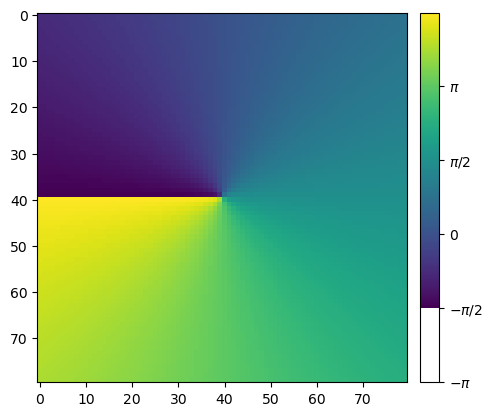

In [47]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
plt.imshow(theta2D)
cax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cb.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
cb.ax.tick_params(labelsize=10)

In [48]:
def get_fourier_params(r, phi, R, v0, v1):
    C0 = (1-v0/v1) * R * (1 - (r**2)/(4*R**2))
    C1 = (1-v0/v1) * r 
    C2 = (1-v0/v1) * r**2 / (4*R)
    phi1, phi2 = phi, phi
    return C0, C1, phi1, C2, phi2

def wavefront_fourier(C0, C1, phi1, C2, phi2):
    return lambda theta: C0 + C1 * torch.cos(theta - phi1) + C2 * torch.cos(2 * (theta - phi2))

def wavefront_real(R, r, phi, v0, v1):
    if r < R:
        return lambda theta: (1-v0/v1) * (torch.sqrt(R**2 - (r*torch.sin(theta-phi))**2) + r * torch.cos(theta-phi))
    else:
        return lambda theta: (1-v0/v1) * 2 * torch.sqrt(torch.maximum(R**2 - (r*torch.sin(theta-phi))**2, torch.zeros_like(theta))) * (torch.cos(phi-theta) >= 0)

def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    psf = ifftshift(ifftn(tf, dim=[-2,-1]), dim=[-2,-1]).abs()
    psf /= psf.sum(axis=(-2,-1)) # Normalization.
    return psf

### $r =< R$

0.0007715884079236962 0.0005315480557593534 8.268525311812165e-05


(0.0, 6.283185307179586)

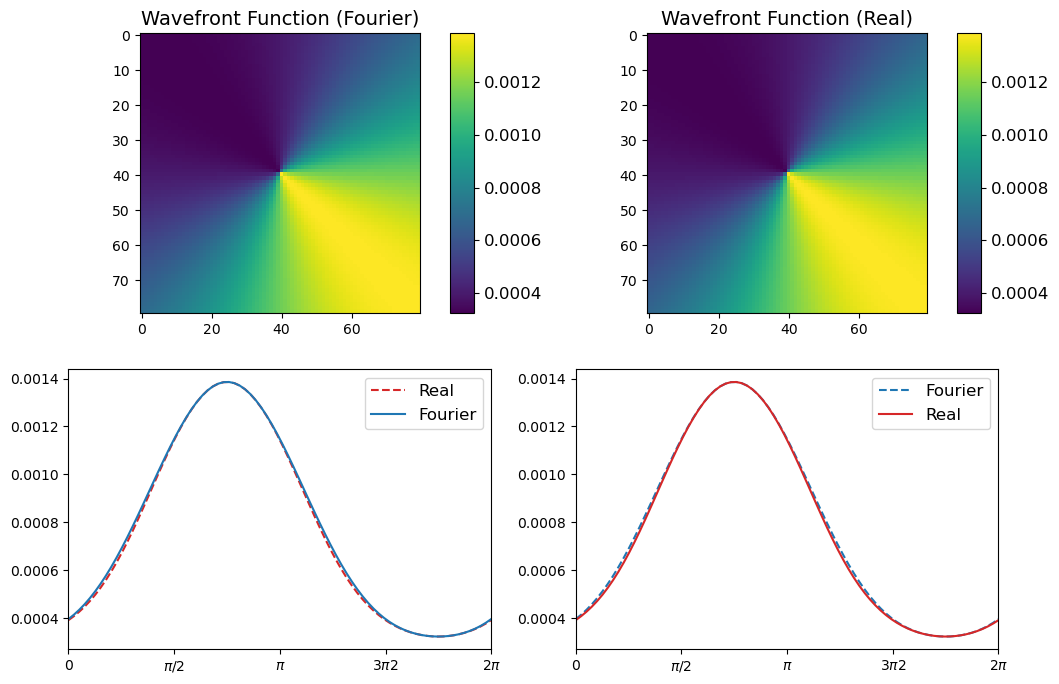

In [49]:
r = 7e-3 # Distance to center [m].
phi = 3*np.pi/4 # Angle to center [rad].
C0, C1, phi1, C2, phi2 = get_fourier_params(r, phi, R, v0, v1)
print(C0, C1, C2)
w_fourier = wavefront_fourier(C0, C1, phi, C2, phi)
w_real = wavefront_real(R, r, phi, v0, v1)

# Visualizations.
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2,2,1)
plt.imshow(w_fourier(theta2D))
ax1.set_title('Wavefront Function (Fourier)', fontsize=14)
cax = fig.add_axes([ax1.get_position().x1+0.025, ax1.get_position().y0, 0.02, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.tick_params(labelsize=12)

ax3 = plt.subplot(2,2,3)
plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real', linestyle='--')
plt.plot(theta1D, w_fourier(theta1D), color='tab:blue', label='Fourier')
ax3.legend(fontsize=12)
ax3.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax3.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$2','2$\pi$'])
ax3.set_xlim([0,2*np.pi])

ax2 = plt.subplot(2,2,2)
plt.imshow(w_real(theta2D))
ax2.set_title('Wavefront Function (Real)', fontsize=14)
cax = fig.add_axes([ax2.get_position().x1+0.025, ax2.get_position().y0, 0.02, ax2.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.tick_params(labelsize=12)

ax4 = plt.subplot(2,2,4)
plt.plot(theta1D, w_fourier(theta1D), color='tab:blue', label='Fourier', linestyle='--')
plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real')
ax4.legend(fontsize=12)
ax4.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax4.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$2','2$\pi$'])
ax4.set_xlim([0,2*np.pi])

# plt.savefig('../figures/wavefront.jpg', bbox_inches='tight')

In [50]:
def get_delays(R, v0, v1, n_delays, mode='linear'):
    if mode == 'linear':
        return np.linspace(0, (1-v0/v1) * R, n_delays)
    elif mode == 'quadric':
        return (1-v0/v1) * R * np.sqrt(np.linspace(0,1,n_delays))
    else:
        raise NotImplementedError
    
n_delays = 8
delays = get_delays(R, v0, v1, n_delays, 'linear')
print(delays)

[0.         0.00012204 0.00024408 0.00036612 0.00048816 0.0006102
 0.00073223 0.00085427]


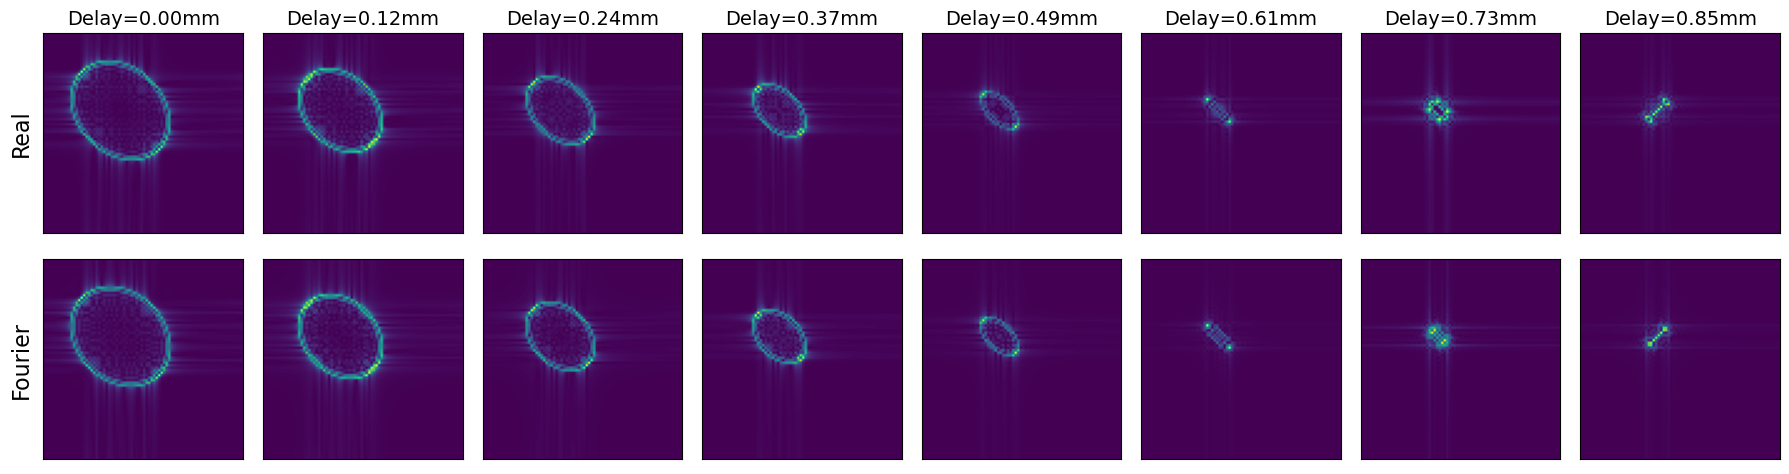

In [51]:
fig = plt.figure(figsize=(18, 5))
for i, (w, label) in enumerate(zip([w_real, w_fourier], ['Real', 'Fourier'])):
    psfs = []
    for j, delay in enumerate(delays):
        psfs.append(PSF(theta2D, k2D, w, delay))
        plt.subplot(2,8,j+1+8*i)
        plt.imshow(psfs[j])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Delay={:.2f}mm'.format(delays[j]*1e3), fontsize=14)
        if j == 0:
            plt.ylabel(label, fontsize=16)

plt.tight_layout()
plt.savefig('../figures/psfs.jpg', bbox_inches='tight')

### $r > R$

(0.0, 6.283185307179586)

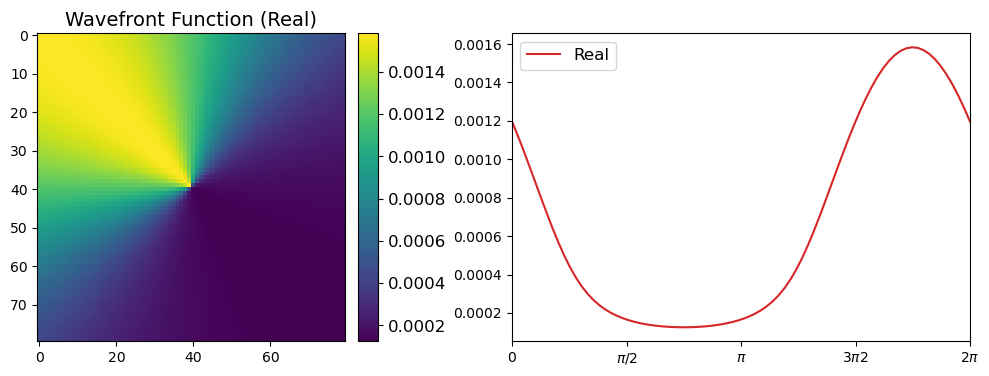

In [52]:
r = 9.6e-3 # Distance to center [m].
phi = -np.pi/4 # Angle to center [rad].
w_real = wavefront_real(R, r, phi, v0, v1)

fig = plt.figure(figsize=(13, 4))

ax2 = plt.subplot(1,2,1)
plt.imshow(w_real(theta2D))
ax2.set_title('Wavefront Function (Real)', fontsize=14)
cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.015, ax2.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.tick_params(labelsize=12)

ax4 = plt.subplot(1,2,2)
plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real')
ax4.legend(fontsize=12)
ax4.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax4.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$2','2$\pi$'])
ax4.set_xlim([0,2*np.pi])

[0.         0.00012204 0.00024408 0.00036612 0.00048816 0.0006102
 0.00073223 0.00085427]


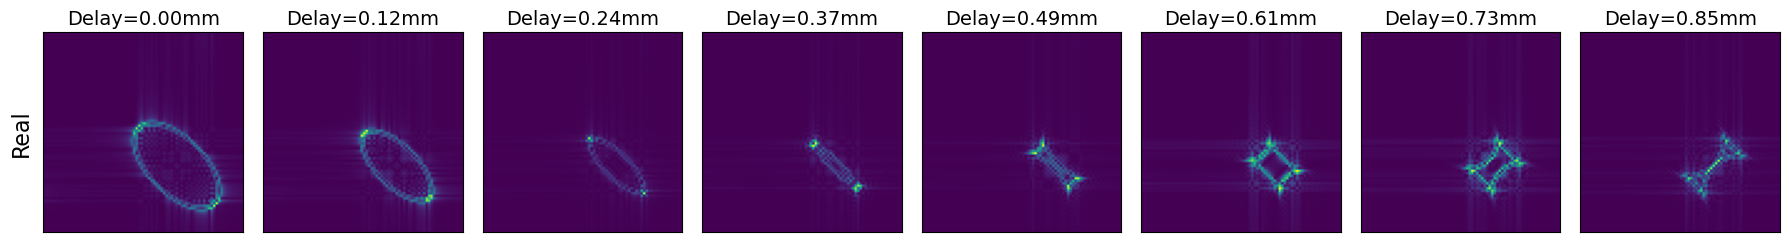

In [53]:
n_delays = 8
delays = get_delays(R, v0, v1, n_delays, 'linear')
print(delays)

fig = plt.figure(figsize=(18, 5))
for i, (w, label) in enumerate(zip([w_real], ['Real'])):
    psfs = []
    for j, delay in enumerate(delays):
        psfs.append(PSF(theta2D, k2D, w, delay))
        plt.subplot(2,8,j+1+8*i)
        plt.imshow(psfs[j])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Delay={:.2f}mm'.format(delays[j]*1e3), fontsize=14)
        if j == 0:
            plt.ylabel(label, fontsize=16)
plt.tight_layout()

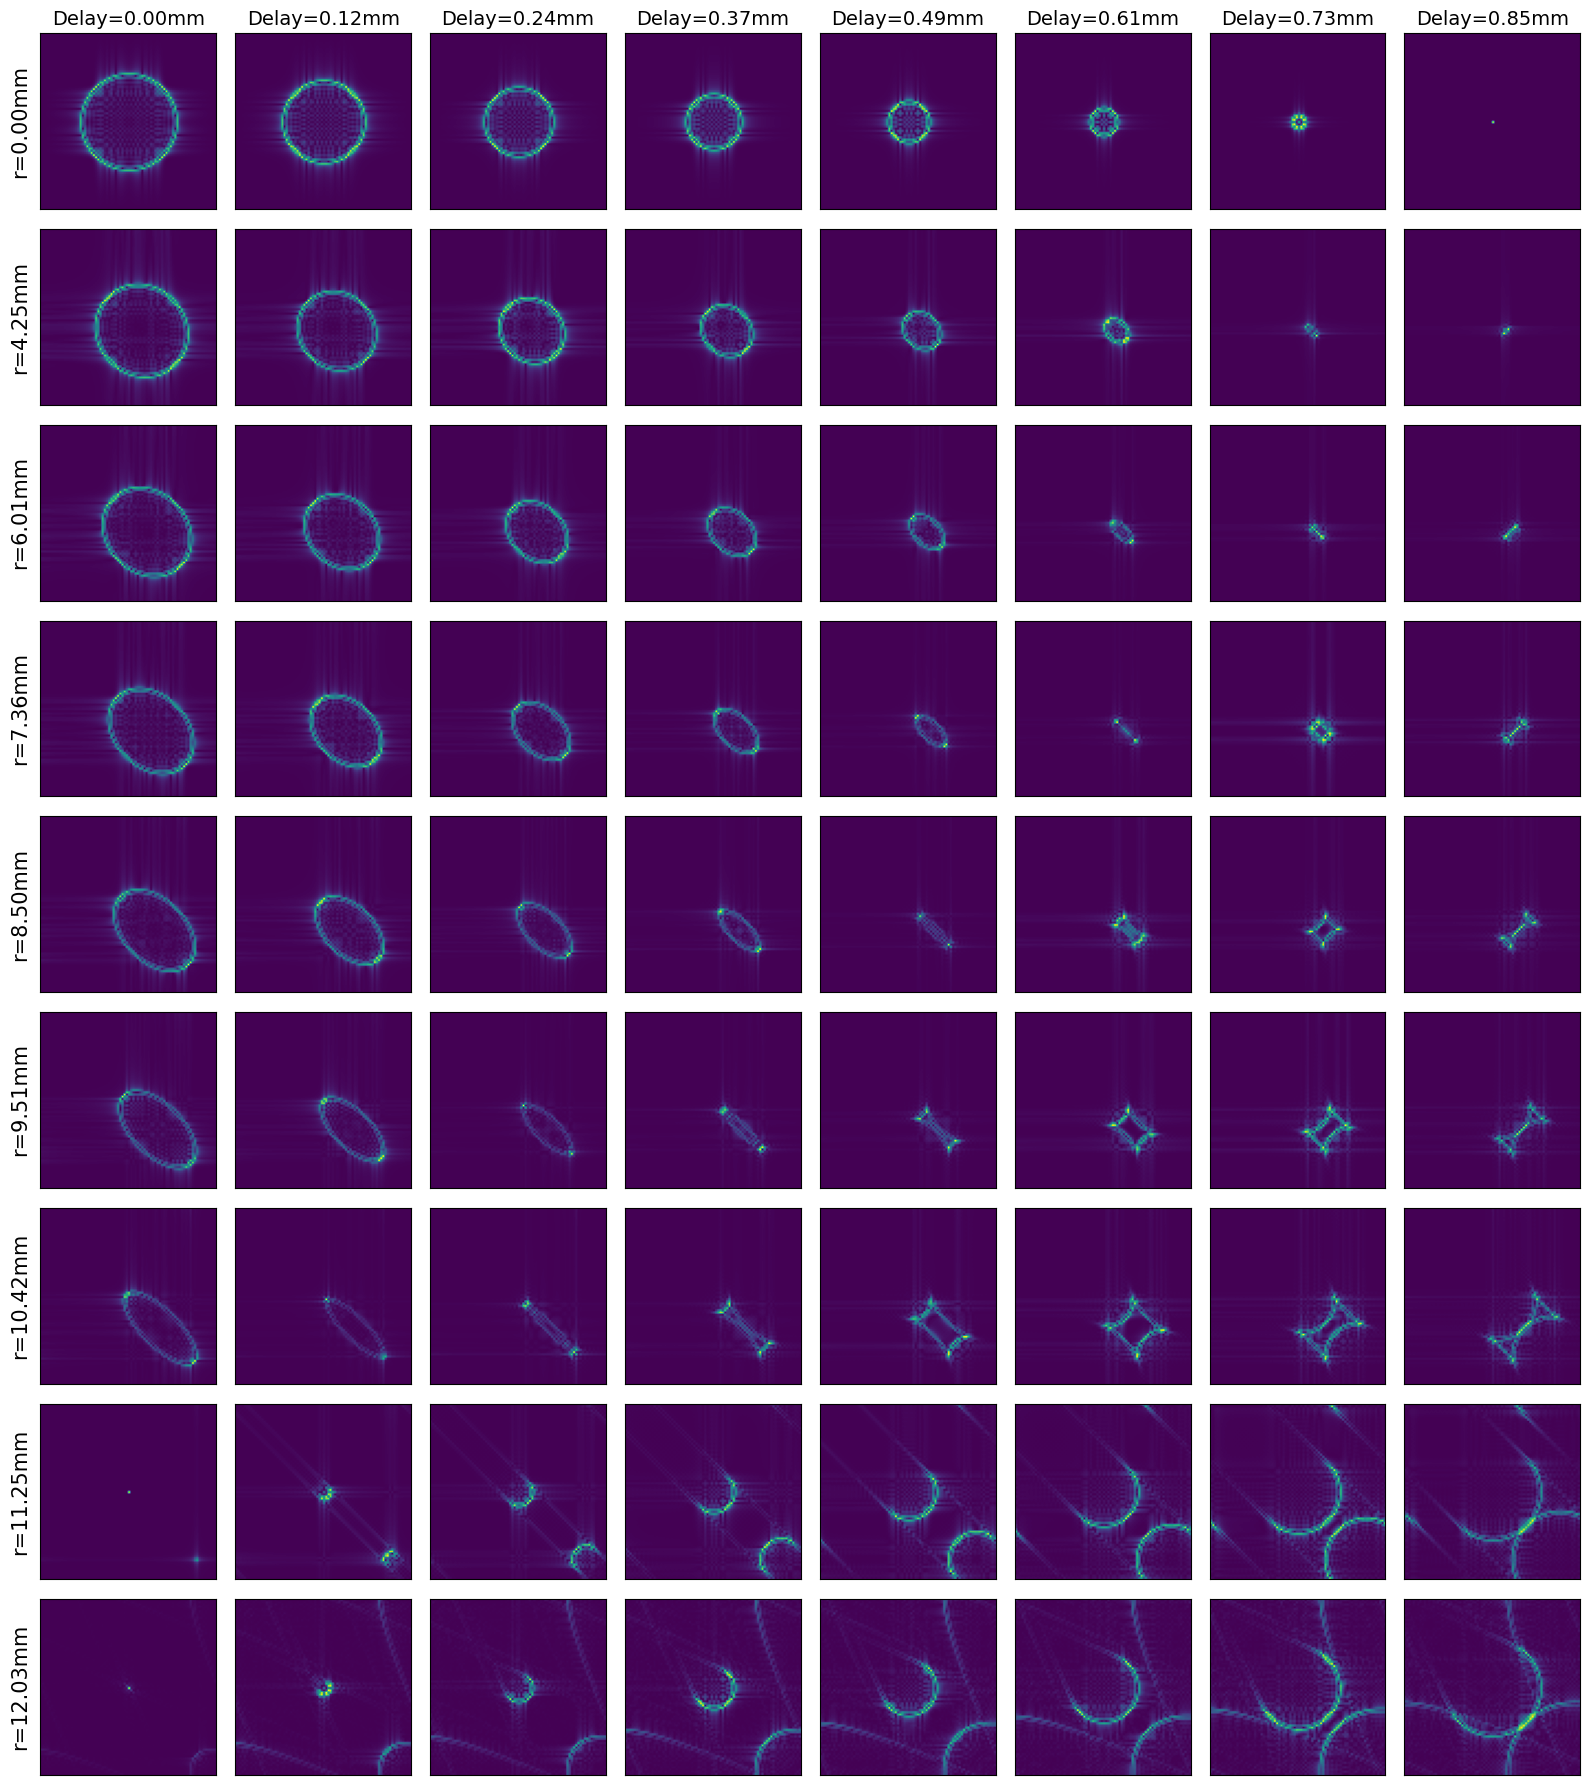

In [54]:
n_delays = 8
delays = get_delays(R, v0, v1, n_delays, 'linear')
rs = np.linspace(0, 9, 9)
rs = R * np.sqrt(rs/[rs[-2]])

fig = plt.figure(figsize=(16, 18))
for i, r in enumerate(rs):
    psfs = []
    w_real = wavefront_real(R, r, phi, v0, v1)
    for j, delay in enumerate(delays):
        psfs.append(PSF(theta2D, k2D, w_real, delay))
        plt.subplot(len(rs), 8, j+1+8*i)
        plt.imshow(psfs[j])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Delay={:.2f}mm'.format(delays[j]*1e3), fontsize=14)
        if j == 0:
            plt.ylabel('r={:.2f}mm'.format(r*1e3), fontsize=15)

plt.tight_layout()